In [1]:
from funcs import *
from tqdm import tqdm
import matplotlib
import string
import plotly.graph_objs as go
from scipy import ndimage, datasets
%matplotlib widget

In [2]:
world_pop = gpd.read_file('./data/pop.geo.json')
world_pop['POP2005']=world_pop['POP2005'].astype(float)
world_pop['area']=  world_pop.to_crs(6933).area.astype(float)*0.000001
world_pop['density'] = (world_pop['POP2005'].div(world_pop['area']))

In [3]:
country_name_index = {}
for i in range(len(world_pop)):
    row_i = world_pop.iloc[i]
    country_name_index.update({row_i['NAME']:i})

In [4]:
polygons_ = get_polygons(world_pop['geometry'])
source_polygons = get_source_polygons(world_pop['geometry'])
N_vec_ = world_pop['POP2005'].values
for i in range(len(N_vec_)):
    if pd.isna(N_vec_[i]):
        N_vec_[i]=1.0
Names_ = world_pop['NAME'].values
Areas_ = world_pop['area'].values

In [5]:
hx = 1.0
hy = 1.0

In [25]:
bounds_ = bounds_by_polygons(polygons_)
xgrid,ygrid = make_grids(hx,hy,bounds_)
Nx = len(xgrid)
Ny = len(ygrid)

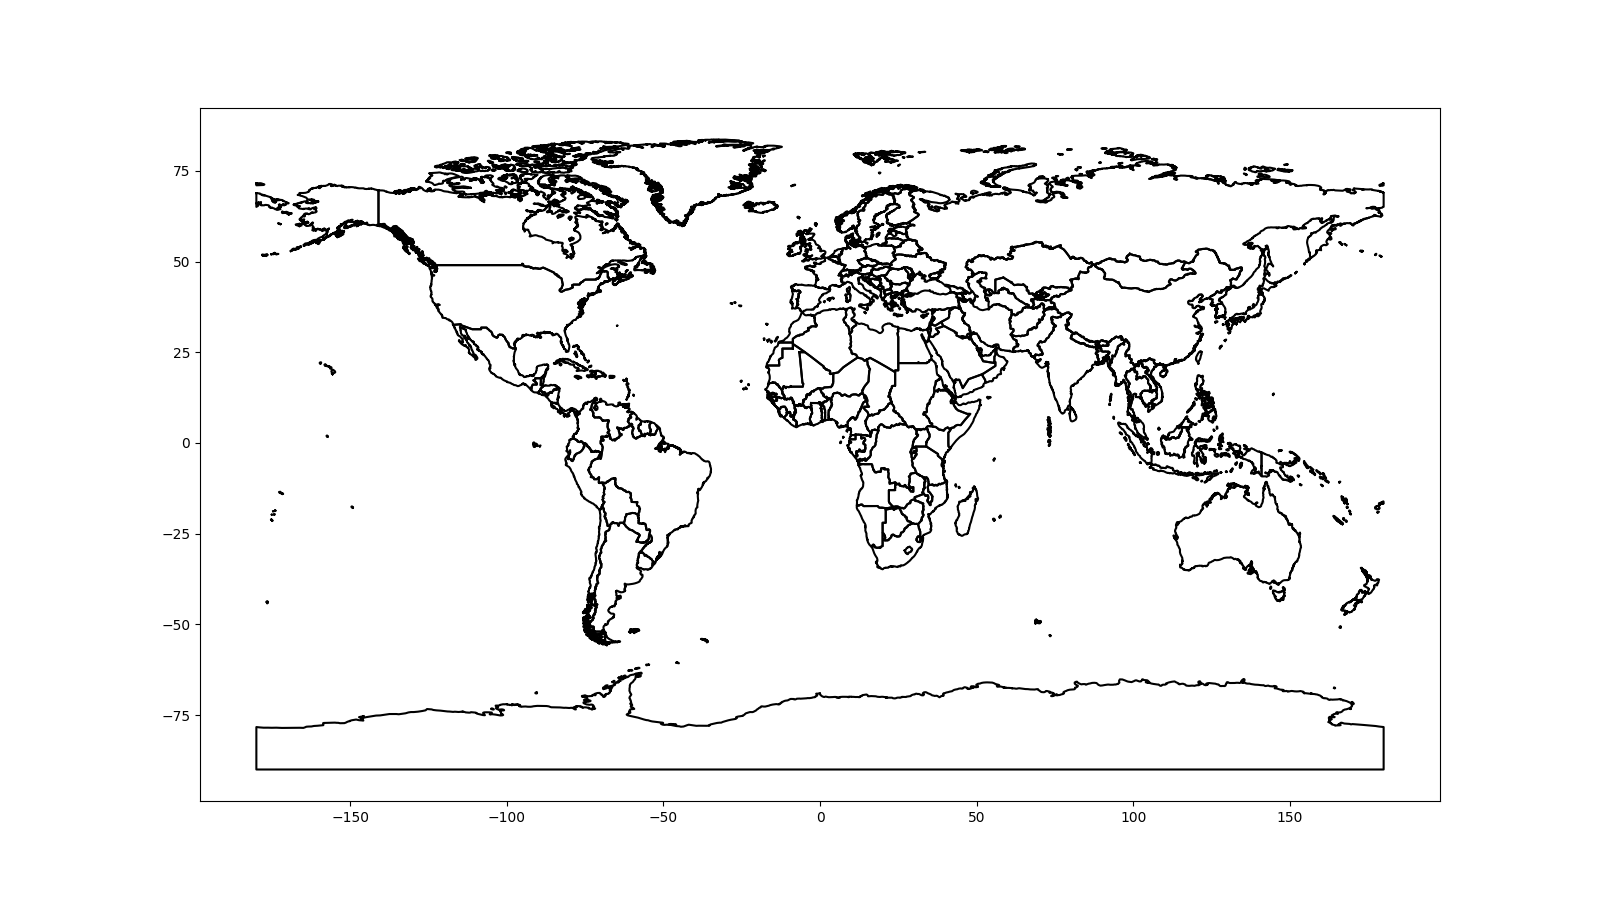

In [7]:
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
for i in range(len(polygons_ )):
    ax.plot(polygons_[i][0],polygons_[i][1],c='k')

In [8]:
masks_per_state = get_binary_mask_per_state_cv2(source_polygons,
                                xgrid, ygrid)
mask_of_earth = CUPmasks(masks_per_state)
mask_of_water = np.logical_not(mask_of_earth)

100%|██████████| 211/211 [00:00<00:00, 370.13it/s]


In [9]:
masks_with_N = [masks_per_state[i].astype(np.float64)*N_vec_[i] for i in range(len(masks_per_state))]

In [10]:
mask_of_earth_N = None 
for i in range(len(masks_with_N)):
    if mask_of_earth_N is None:
        mask_of_earth_N = masks_with_N[i]
    else:
        mask_of_earth_N += masks_with_N[i]

In [11]:
cities = pd.read_csv('./data/worldcities.csv')

In [12]:
cities_mask = np.zeros(shape=(len(xgrid),len(ygrid)),dtype=np.float64)
for i in range(len(cities)):
    x = cities.iloc[i]['lng']
    y = cities.iloc[i]['lat']
    z = cities.iloc[i]['population']
    xi = int((x-xgrid[0])/(xgrid[-1]-xgrid[0])*(len(xgrid)-1))
    yi = int((y-ygrid[0])/(ygrid[-1]-ygrid[0])*(len(ygrid)-1))
    if pd.isna(z):
        z = 1.0
    cities_mask[xi][yi] +=  z

In [22]:
poly_per_state = get_polygons_per_state(world_pop['geometry'])

In [23]:
borders_per_state = get_binary_mask_per_state(poly_per_state,xgrid,ygrid,hx,hy)
all_borders_ = CUPmasks(borders_per_state)
# all_borders_ = ndimage.median_filter(all_borders_, size=2)
kmask = 1.0-np.logical_or(all_borders_.astype(bool), mask_of_water).astype(np.float64)

100%|██████████| 211/211 [00:02<00:00, 81.56it/s] 


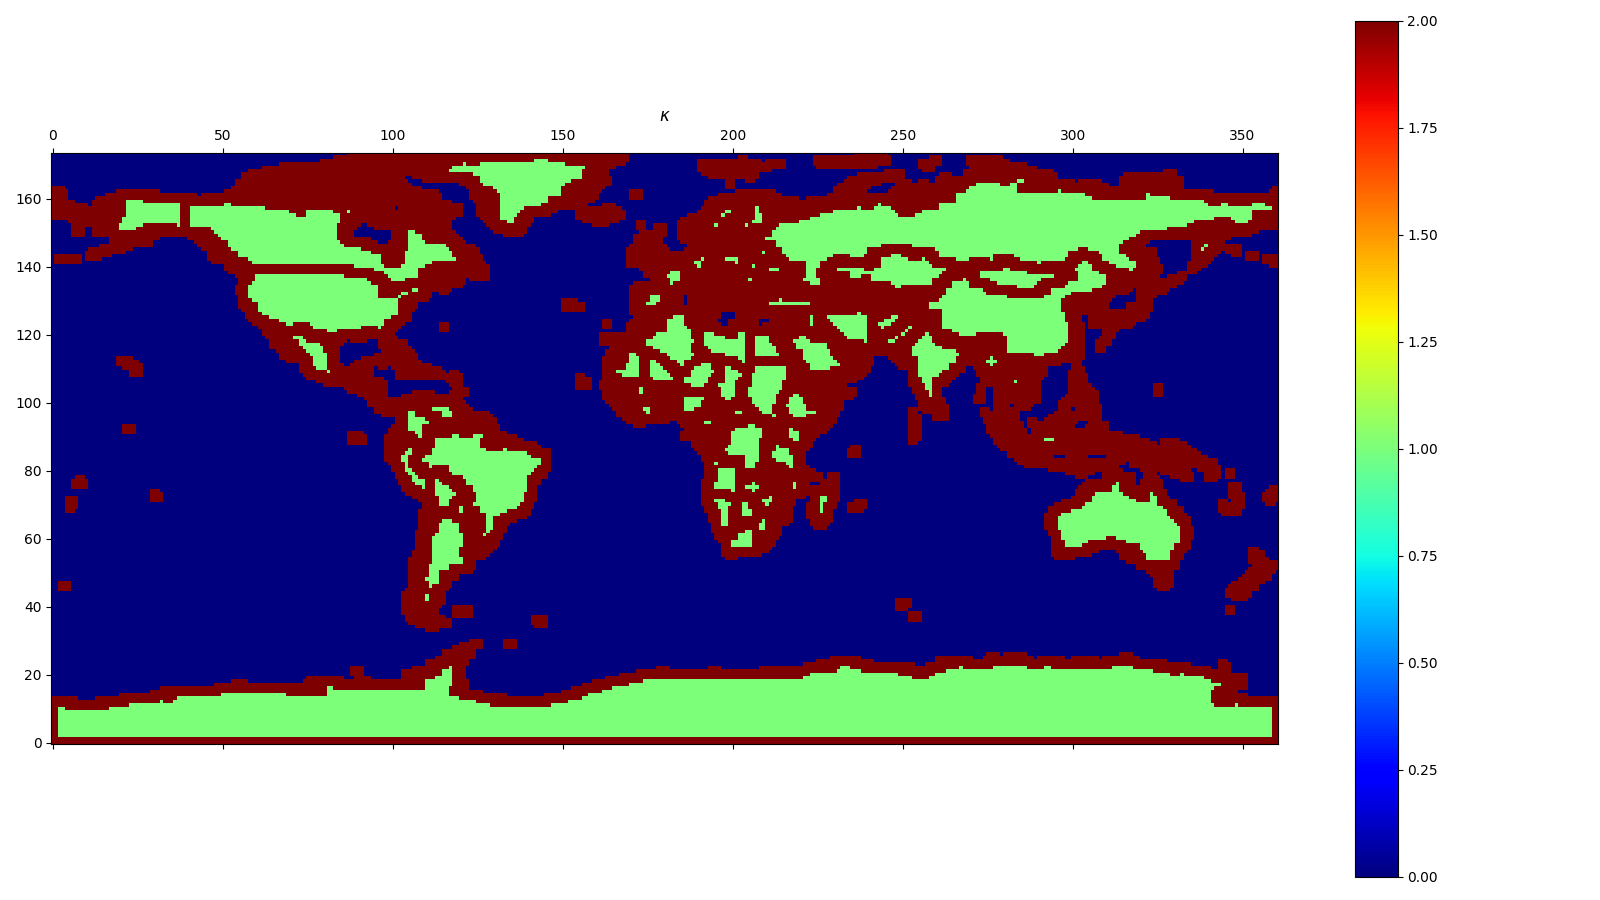

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(16,9)
cax = ax.matshow((kmask + 2.0*all_borders_).T,cmap=matplotlib.cm.jet)
cbar = fig.colorbar(cax)
ax.invert_yaxis()
ax.set_title(r'$\kappa$')
fig.subplots_adjust(left=0.0, bottom=0.0)
fig.tight_layout()

In [90]:
u_nu = np.zeros(shape=(Nx,Ny))
total_unaccounted = 0.0
total_sum_ = 0.0

for i in range(len(masks_per_state)):
    state_mask = masks_per_state[i].astype(bool)
    state_border_mask = borders_per_state[i].astype(bool)
    internal_mask_ = np.logical_and(np.logical_not(state_border_mask), state_mask).astype(np.float64)
    border_people_amt_ = np.sum(cities_mask*state_border_mask.astype(np.float64))
    vertex_amt_internal_ = np.sum(internal_mask_)
    if vertex_amt_internal_ ==0.0:
        total_unaccounted += border_people_amt_
        continue
    total_sum_ += border_people_amt_
    internal_people_ = internal_mask_*cities_mask + border_people_amt_/vertex_amt_internal_*internal_mask_
    u_nu += internal_people_

where_not_zero = u_nu !=0.0
vertex_amnt_where_not_zero = np.sum(where_not_zero)
u_nu[where_not_zero] += total_unaccounted/vertex_amnt_where_not_zero
u_nu[where_not_zero] = u_nu[where_not_zero]/np.sum(u_nu)*np.sum(N_vec_)


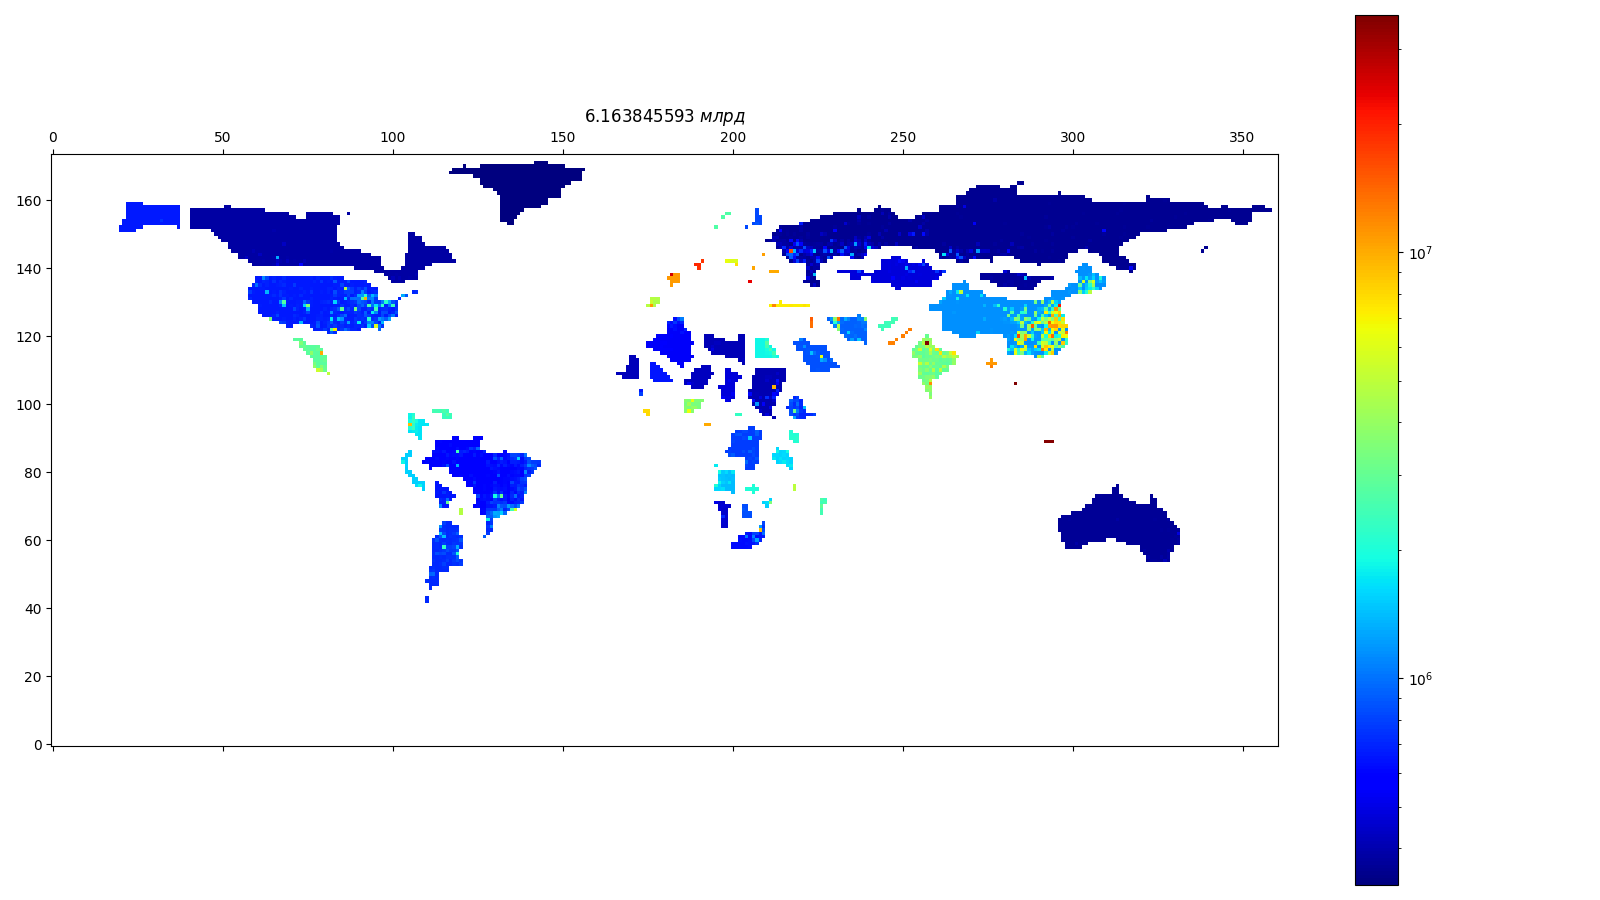

In [91]:
fig, ax = plt.subplots()
fig.set_size_inches(16,9)
cax = ax.matshow(u_nu.T,cmap=matplotlib.cm.jet,norm=matplotlib.colors.LogNorm())
cbar = fig.colorbar(cax)
ax.invert_yaxis()
ax.set_title(r'${} \ млрд$'.format(np.sum(u_nu)/10**9))
fig.subplots_adjust(left=0.0, bottom=0.0)
fig.tight_layout()

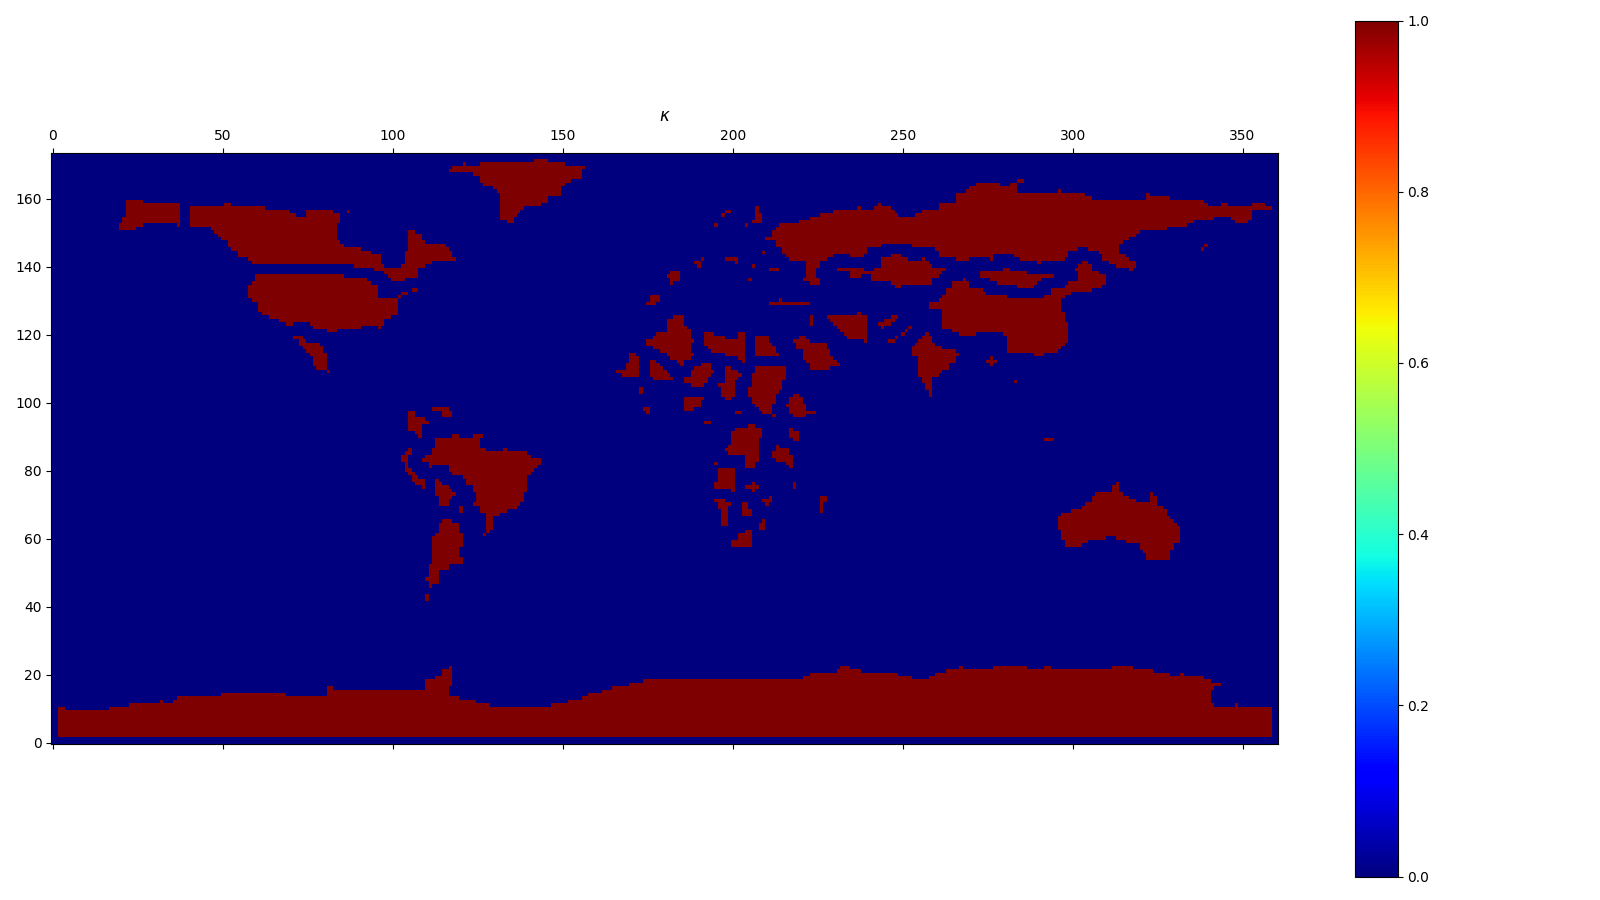

In [78]:
fig, ax = plt.subplots()
fig.set_size_inches(16,9)
cax = ax.matshow(kmask.T,cmap=matplotlib.cm.jet)
cbar = fig.colorbar(cax)
ax.invert_yaxis()
ax.set_title(r'$\kappa$')
fig.subplots_adjust(left=0.0, bottom=0.0)
fig.tight_layout()

In [79]:
@jit(nopython=True)
def F(t,x,y,u):
    return 0.0
@jit(nopython =True)
def D(x,y,u,kmask,xindex,yindex):
    return kmask[xindex][yindex]
@jit(nopython=True)
def solve(Nx,Ny,Nt,hx,hy,tau,t,x,y,u_,years_,water_mask_,earth_,kmask):
    solutions = np.zeros(shape=(len(years_),Nx,Ny))
    solutions[0] = np.copy(u_)
    u = np.copy(u_)
    end_ = False
    l_ = 1
    u_next = np.zeros(shape=(Nx,Ny))
    for k in range(Nt-1):
        print(k,Nt, np.sum(u)/10**9)
        u_s = np.copy(u)
        for i in range(1,Nx-1):
            for j in range(1,Ny-1):
                L_x = 1.0/hx**2*(u[i+1][j]-u[i][j])*np.sqrt(D(x[i+1],y[j],u[i+1][j],kmask,i+1,j)*D(x[i],y[j],u[i][j],kmask,i,j)) - 1.0/hx**2*(u[i][j]-u[i-1][j])*np.sqrt(D(x[i],y[j],u[i][j],kmask,i,j)*D(x[i-1],y[j],u[i-1][j],kmask,i-1,j))
                L_y = 1.0/hy**2*(u[i][j+1]-u[i][j])*np.sqrt(D(x[i],y[j+1],u[i][j+1],kmask,i,j+1)*D(x[i],y[j],u[i][j],kmask,i,j)) - 1.0/hy**2*(u[i][j]-u[i][j-1])*np.sqrt(D(x[i],y[j],u[i][j],kmask,i,j)*D(x[i],y[j-1],u[i][j-1],kmask,i,j-1))
                u_next[i][j] = u[i][j] + tau*(L_x+ L_y + F(t[k],x[i],y[j],u[i][j]))
        is_nan = np.sum(np.isnan(u_next)) > 0
        is_inf = np.sum(np.isinf(u_next)) > 0
        is_neg = np.sum(u_next < 0.0) > 0
        if is_nan or is_inf or is_neg: 
            end_ = True
            if is_nan:
                print('nan')
            if is_inf:
                print('inf')
            if is_neg:
                print('neg')
        if end_:
            return solutions[:l_]
        u = np.copy(u_next)
        for ye_ in years_:
            if ye_ == t[k+1]:
                solutions[l_] = np.copy(u_next)
                l_ +=1  
    return solutions

In [92]:
tau = hx/10**3
T = 20.0
t0 = 2005.0
Nt = int((t0+T-t0)/tau) + 1
years_ = np.arange(t0,T+t0)
tgrid = np.linspace(start=t0, stop=t0+T,num=Nt)
t = np.copy(tgrid)
x = np.copy(xgrid)
y = np.copy(ygrid)
u_vec = solve(Nx,Ny,Nt,hx,hy,tau,t,x,y,u_nu,years_,mask_of_water.astype(np.float64),mask_of_earth.astype(np.float64),kmask)

0 20001 6.163845592999574
1 20001 6.163845592999711
2 20001 6.163845592999815
3 20001 6.163845592999926
4 20001 6.16384559299992
5 20001 6.163845592999931
6 20001 6.16384559299993
7 20001 6.1638455929999605
8 20001 6.163845592999925
9 20001 6.163845592999952
10 20001 6.163845592999963
11 20001 6.163845592999977
12 20001 6.163845592999962
13 20001 6.163845592999982
14 20001 6.1638455929999845
15 20001 6.163845592999946
16 20001 6.1638455929999845
17 20001 6.163845592999991
18 20001 6.16384559299994
19 20001 6.163845592999978
20 20001 6.163845592999989
21 20001 6.1638455929999685
22 20001 6.1638455929999685
23 20001 6.163845592999993
24 20001 6.163845593000009
25 20001 6.163845593000003
26 20001 6.163845593000001
27 20001 6.163845592999994
28 20001 6.163845593000002
29 20001 6.1638455929999685
30 20001 6.163845592999976
31 20001 6.163845592999997
32 20001 6.163845592999992
33 20001 6.163845592999988
34 20001 6.16384559300002
35 20001 6.163845593000006
36 20001 6.163845592999986
37 20001 

Text(0.5, 1.0, 'учетка без источников')

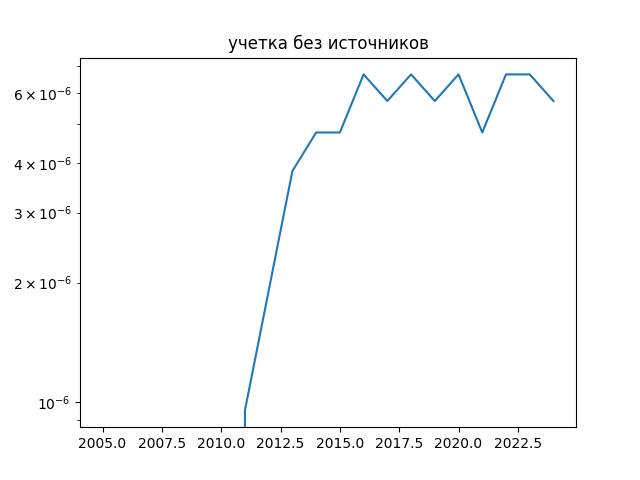

In [93]:
fig,ax = plt.subplots()
ax.plot(years_[:len(u_vec)], [np.abs(np.sum(u_vec[0])-np.sum(el)) for el in u_vec])
ax.set_yscale('log')
ax.set_title('учетка без источников')

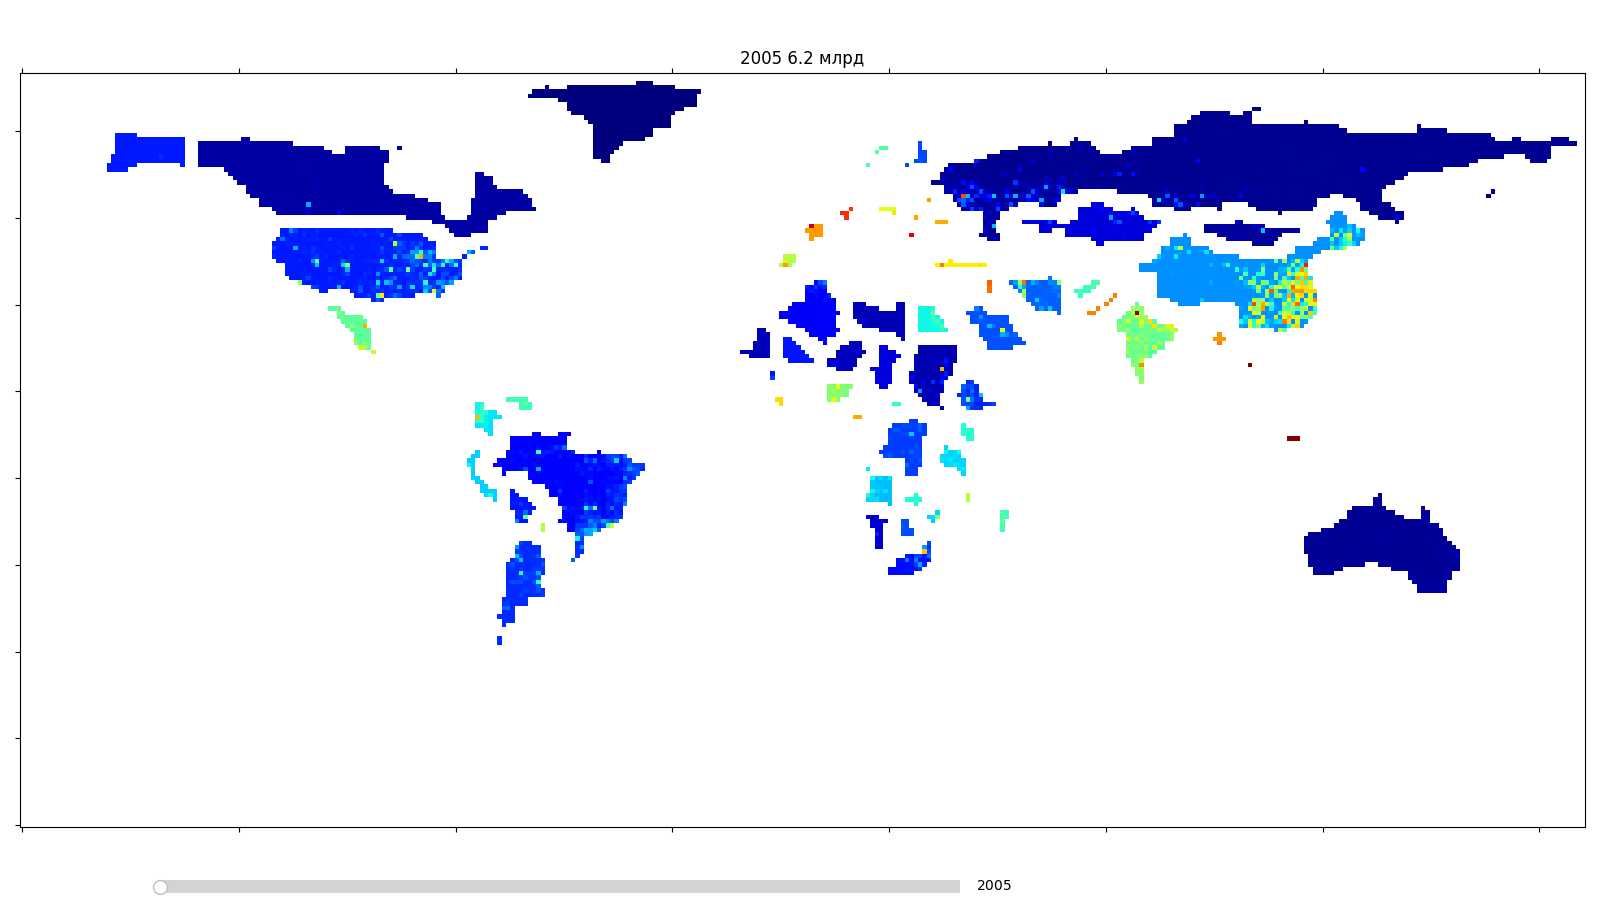

In [96]:
from matplotlib.widgets import Button, Slider

fig, ax = plt.subplots()
ax.set_xticklabels([])
ax.set_yticklabels([])
fig.set_size_inches(16,9)
cax = ax.matshow(u_vec[0].T,cmap=matplotlib.cm.jet,norm=matplotlib.colors.LogNorm())
ax.set_title(f'{int(years_[0])} {np.round(np.sum(u_vec[0])/10**9,1)} млрд')
ax.invert_yaxis()
fig.subplots_adjust(left=0.0, bottom=0.0)
# cbar = fig.colorbar(cax)
fig.tight_layout()

axfreq = fig.add_axes([0.1, 0.0, 0.5, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='',
    valmin=years_[0],
    valmax=years_[-1],
    valinit=years_[0]
)

def update(val):
    # ax.matshow(solutions_[0].T,cmap=matplotlib.cm.jet,norm=matplotlib.colors.LogNorm())
    cax.set_data(u_vec[int(val- years_[0])].T)
    ax.set_title(f'{int(val)} {np.round(np.sum(u_vec[int(val- years_[0])])/10**9,1)} млрд')
    fig.canvas.draw_idle()
    # plt.draw()

freq_slider.on_changed(update)
plt.show()